##### Modules

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

import numpy as np
from data_handler import DataHandler
from droplet_model import DropletModel, ReparameterisedDropletModel
from parameter_fitting import ParameterFitting
from plots import Plots
import matplotlib.pyplot as plt
import pints
import pints.plot
from scipy.integrate import odeint
from numba import njit
import seaborn as sns
from cycler import cycle


##### Likelihoods

In [2]:
class AdditiveNormalSigmaMLEIndicatorLogLikelihood(pints.ProblemLogLikelihood):

    def __init__(self, problem, zero_tol=0.0):
        """
        Parameters
        ----------
        problem : pints.Problem
            the PINTS problem that provides .n_outputs(), .n_times(), .evaluate(x) etc.
        zero_tol : float
            any sse <= zero_tol is treated as "zero error" and that output is ignored.
            Use 0.0 to ignore only exact zeros or something like 1e-16 for numerical safety.
        """
        super(AdditiveNormalSigmaMLEIndicatorLogLikelihood, self).__init__(problem)
        self._no = problem.n_outputs()
        self._np = problem.n_parameters()
        self._nt = problem.n_times()
        self._zero_tol = float(zero_tol)



    def __call__(self, x):
        # evaluate residuals: shape (nt, no) or broadcasting equivalent as in your code
        error = self._values - self._problem.evaluate(x)

        # sum of squared errors per output
        sse = np.sum(error**2, axis=0) / float(self._nt)  # length = no

        # mask outputs that have non-zero SSE (use numeric tolerance)
        mask = sse > self._zero_tol
        k = int(np.count_nonzero(mask))  # number of included outputs

        # if nothing remains, return -inf (log-likelihood impossible under this param)
        if k == 0:
            return -np.inf

        # use only positive/valid SSEs
        sse_valid = sse[mask]

        # log term from MLE substitution: -0.5 * sum(log(sse_valid))
        log_term = -0.5 * np.sum(np.log(sse_valid))

        # offset depends on how many outputs were included
        offset = -0.5 * k * self._nt * (np.log(2.0 * np.pi) + 1.0)

        return offset + log_term

##### Functions

In [93]:
def get_sigma_MLEs(
    model, 
    data, 
    mle_params, 
    data_times, 
    noise_model="additive normal"
):

    opt_model_sol = model.simulate(mle_params, data_times)
    residuals = opt_model_sol - data

    n_t = len(data_times)

    if noise_model == "additive normal":

        sigma_MLEs = np.sqrt((1 / n_t) * np.sum(residuals**2, axis=0))

    elif noise_model == "multiplicative normal":

        sigma_MLEs = np.sqrt((1 / n_t) * np.sum(residuals**2 / opt_model_sol, axis=0))

    elif noise_model == "lognormal":

        log_residuals = np.log(data) - np.log(opt_model_sol)

        log_residuals = np.nan_to_num(log_residuals, nan=0)

        sigma_MLEs = np.sqrt((1 / n_t) * np.sum(log_residuals**2, axis=0))

    return sigma_MLEs





def get_mcmc_chains(
    log_likelihood,
    apply_log_transform = False,
    mcmc_method = pints.HaarioBardenetACMC,
    max_mcmc_iterations = 30000,
    num_chains = 4,
    prior_lower_bounds = [1e1, 1e-10, 1e-2],
    prior_upper_bounds = [1e4, 1e0, 1e1],
    initial_mcmc_points=None,
    log_to_screen=True
):


    prior_bounds = pints.RectangularBoundaries(prior_lower_bounds, prior_upper_bounds)
    log_prior = pints.UniformLogPrior(prior_bounds)


    if initial_mcmc_points is None:
        initial_mcmc_points = log_prior.sample(num_chains)


    mcmc_transform = None
    if apply_log_transform:

        mcmc_transform = pints.LogTransformation(n_parameters=len(prior_lower_bounds))

    log_posterior = pints.LogPosterior(log_likelihood, log_prior)

    mcmc = pints.MCMCController(log_posterior, num_chains, initial_mcmc_points, method=mcmc_method, transformation=mcmc_transform)
    mcmc.set_max_iterations(max_mcmc_iterations)
    # mcmc.set_parallel(True)
    mcmc.set_log_to_screen(log_to_screen)

    chains = mcmc.run()

    return chains

def plot_mle_solution(
    model, 
    data,
    data_times,
    param_mles,
    z_value = 1.96,
    max_size_shown=None,
    fig_size=(8,5)
):
    
    fig, ax = plt.subplots(figsize=fig_size)
    
    model_params = [
        param_mles["b"],
        param_mles["f"],
        param_mles["g"]
    ]

    sigma_mles = param_mles["sigma_mles"]

    num_model_times = 200
    model_times = np.linspace(4, 14, num_model_times)

    num_outputs = model.n_outputs()
    if max_size_shown is None:
        max_size_shown = num_outputs
    
    opt_model_sol = model.simulate(params=model_params, times=model_times)


    palette = sns.color_palette("Set1", n_colors=max_size_shown)
    colour_cycle = cycle(palette)

    for n in range(max_size_shown):

        opt_model_sol_n = opt_model_sol[:, n]
        model_lower = opt_model_sol_n - z_value * sigma_mles[n]
        model_upper = opt_model_sol_n + z_value * sigma_mles[n]


        plot_colour = next(colour_cycle)
        ax.plot(data_times, data[:, n], marker='s', markersize=10, markeredgecolor='k', linestyle='--', label='data', c=plot_colour)
        ax.plot(model_times, opt_model_sol_n, linewidth=4, label='model', c=plot_colour)
        ax.fill_between(model_times,model_lower,model_upper,color=plot_colour,alpha=0.1,label=f'95% CI')

    ax.set_xlabel(r'$t$ (days)')
    ax.set_ylabel(r'$\phi_n(t)$')
    plt.show()


def plot_map_series(
    model, 
    data,
    data_times,
    param_maps,
    z_value = 1.96,
    max_size_shown=None,
    fig_size=(8,5)
):
    
    fig, ax = plt.subplots(figsize=fig_size)
    

    num_model_times = 200
    model_times = np.linspace(4, 14, num_model_times)

    num_outputs = model.n_outputs()
    if max_size_shown is None:
        max_size_shown = num_outputs
    
    opt_model_sol = model.simulate(params=param_maps, times=model_times)


    palette = sns.color_palette("Set1", n_colors=max_size_shown)
    colour_cycle = cycle(palette)

    for n in range(max_size_shown):

        opt_model_sol_n = opt_model_sol[:, n]



        plot_colour = next(colour_cycle)
        ax.plot(data_times, data[:, n], marker='s', markersize=10, markeredgecolor='k', linestyle='--', label='data', c=plot_colour)
        ax.plot(model_times, opt_model_sol_n, linewidth=4, label='model', c=plot_colour)

    ax.set_xlabel(r'$t$ (days)')
    ax.set_ylabel(r'$\phi_n(t)$')
    plt.show()

def plot_series(samples, problem, num_ouputs_shown, ref_parameters=None, thinning=None):
    """
    Creates and returns a plot of predicted time series for a given list of
    ``samples`` and a single-output or multi-output ``problem``.

    Because this method runs simulations, it can take a considerable time to
    run.

    Returns a ``matplotlib`` figure object and axes handle.

    Parameters
    ----------
    samples
        A list of samples, with shape ``(n_samples, n_parameters)``, where
        `n_samples` is the number of samples in the list and ``n_parameters``
        is the number of parameters.
    problem
        A :class:``pints.SingleOutputProblem`` or
        :class:``pints.MultiOutputProblem`` of a n_parameters equal to or
        greater than the ``n_parameters`` of the `samples`. Any extra
        parameters present in the chain but not accepted by the
        ``SingleOutputProblem`` or ``MultiOutputProblem`` (for example
        parameters added by a noise model) will be ignored.
    ref_parameters
        A set of parameters for reference in the plot. For example,
        if true values of parameters are known, they can be passed in for
        plotting.
    thinning
        An integer exceeding zero. If specified, only every
        n-th sample (with ``n = thinning``) in the samples will be used. If
        left at the default value ``None``, a value will be chosen so that
        200 to 400 predictions are shown.
    """
    import matplotlib.pyplot as plt

    # Check samples size
    try:
        n_sample, n_param = samples.shape
    except ValueError:
        raise ValueError('`samples` must be of shape (n_sample,'
                         + ' n_parameters).')

    # Get problem n_parameters
    n_parameters = problem.n_parameters()

    # Check reference parameters
    if ref_parameters is not None:
        if len(ref_parameters) != n_param and \
                len(ref_parameters) != n_parameters:
            raise ValueError(
                'Length of `ref_parameters` must be same as number of'
                ' parameters.')
        ref_series = problem.evaluate(ref_parameters[:n_parameters])

    # Get number of problem output
    n_outputs = problem.n_outputs()

    # Get thinning rate
    if thinning is None:
        thinning = max(1, int(n_sample / 200))
    else:
        thinning = int(thinning)
        if thinning < 1:
            raise ValueError(
                'Thinning rate must be `None` or an integer greater than'
                ' zero.')

    # Get times
    times = problem.times()

    # Evaluate the model for all parameter sets in the samples
    i = 0
    predicted_values = []
    for params in samples[::thinning, :n_parameters]:
        predicted_values.append(problem.evaluate(params))
        i += 1
    predicted_values = np.array(predicted_values)
    mean_values = np.mean(predicted_values, axis=0)

    # Guess appropriate alpha (0.05 worked for 1000 plots)
    alpha = min(1, max(0.05 * (1000 / (n_sample / thinning)), 0.5))

    # Plot prediction
    fig, axes = plt.subplots(num_ouputs_shown, 1, figsize=(8, np.sqrt(n_outputs) * 3),
                             sharex=True)

    if n_outputs == 1:
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.plot(
            times, problem.values(), 'x', color='#7f7f7f', ms=6.5, alpha=0.5,
            label='Original data')
        plt.plot(
            times, predicted_values[0], color='#1f77b4',
            label='Inferred series')
        for v in predicted_values[1:]:
            plt.plot(times, v, color='#1f77b4', alpha=alpha)
        plt.plot(times, mean_values, 'k:', lw=2,
                 label='Mean of inferred series')

        # Add reference series if given
        if ref_parameters is not None:
            plt.plot(times, ref_series, color='#d62728', ls='--',
                     label='Reference series')

        plt.legend()

    elif n_outputs > 1:
        # Remove horizontal space between axes and set common xlabel
        fig.subplots_adjust(hspace=0)
        axes[-1].set_xlabel('Time')

        # Go through each output
        for i_output in range(num_ouputs_shown):
            axes[i_output].set_ylabel('Output %d' % (i_output + 1))
            axes[i_output].plot(
                times, problem.values()[:, i_output], 'x', color='#7f7f7f',
                ms=6.5, alpha=0.5, label='Original data')
            axes[i_output].plot(
                times, predicted_values[0][:, i_output], color='#1f77b4',
                label='Inferred series')
            for v in predicted_values[1:]:
                axes[i_output].plot(times, v[:, i_output], color='#1f77b4',
                                    alpha=alpha)
            axes[i_output].plot(times, mean_values[:, i_output], 'k:', lw=2,
                                label='Mean of inferred series')

            # Add reference series if given
            if ref_parameters is not None:
                axes[i_output].plot(times, ref_series[:, i_output],
                                    color='#d62728', ls='--',
                                    label='Reference series')

        axes[0].legend()

    plt.tight_layout()
    return fig, axes


def posterior_predictive_plot(
    model,
    data,
    model_param_chains,
    max_size_shown=4,
    num_samples=100,
    sigma_values=None,
    noise_model="additive normal",
    fixed_parameter=None,
    fixed_parameter_value=None,
    rng=None,
    fig_size=(8,5)
):

    num_chains, max_mcmc_iterations, _ = model_param_chains.shape

    # If no parameter is fixed, just return the original chains
    if fixed_parameter is None:
        corrected_chains = model_param_chains

    else:
        # We expect 3 total parameters when one is fixed
        corrected_chains = np.zeros((num_chains, max_mcmc_iterations, 3))

        # Fill with fixed value everywhere for the chosen parameter
        if fixed_parameter == "b":
            corrected_chains[:, :, 0] = fixed_parameter_value
            corrected_chains[:, :, 1:] = model_param_chains  # assumes model_param_chains has shape (..., 2)

        elif fixed_parameter == "f":
            corrected_chains[:, :, 1] = fixed_parameter_value
            corrected_chains[:, :, 0] = model_param_chains[:, :, 0]
            corrected_chains[:, :, 2] = model_param_chains[:, :, 1]

        elif fixed_parameter == "g":
            corrected_chains[:, :, 2] = fixed_parameter_value
            corrected_chains[:, :, :2] = model_param_chains

        else:
            raise ValueError(f"Unknown fixed_parameter '{fixed_parameter}'")
    

    data_times = np.asarray([4,6,8,11,14])
    model_times = np.linspace(4, 14, 200)

    if rng is None:
        rng = np.random.default_rng()



    burnt_in_chains = corrected_chains[:, int(corrected_chains.shape[1]/2):, :]
    stacked_chains = np.vstack(burnt_in_chains)

    num_theta_samples = min(num_samples, max_mcmc_iterations)
    idx = rng.choice(max_mcmc_iterations, size=num_theta_samples, replace=False)
    theta_samples = stacked_chains[idx, :]

    model_sol_samples = np.asarray([model.simulate(theta, model_times) for theta in theta_samples]) # [num samples, num times, num outputs]

    S, T, N = model_sol_samples.shape

    full_predictions = np.zeros((S, T, N))

    for s in range(S):

        model_sol_sample = model_sol_samples[s]

        eps = rng.normal(loc=0.0, scale=sigma_values.reshape(1, N), size=(T, N))

        if noise_model == "additive normal":

            prediction = model_sol_sample + eps
            
        elif noise_model == "multiplicative normal":

            prediction = model_sol_sample * (1 + eps)

        elif noise_model == "lognormal":

            prediction = model_sol_sample * np.exp(eps)

        full_predictions[s] = prediction


    # percentiles: result shape (3, T, N) for [2.5, 50, 97.5]
    model_sol_percentiles = np.percentile(full_predictions, [2.5, 50.0, 97.5], axis=0)
    model_sol_lower = model_sol_percentiles[0, :, :]   # shape (T, N)
    model_sol_upper = model_sol_percentiles[2, :, :]

    mean_params = np.mean(stacked_chains, axis=0)
    model_sol_mean = model.simulate(mean_params, model_times)

    fig, ax = plt.subplots(figsize=fig_size)
    
    num_outputs = model.n_outputs()
    if max_size_shown is None:
        max_size_shown = num_outputs
    
    palette = sns.color_palette("Set1", n_colors=max_size_shown)
    colour_cycle = cycle(palette)


    for n in range(max_size_shown):

        

        plot_colour = next(colour_cycle)

        ax.fill_between(model_times, model_sol_lower[:, n], model_sol_upper[:, n], color=plot_colour, alpha=0.25, label='95% CI')
        ax.plot(model_times, model_sol_mean[:, n], color=plot_colour, lw=2, label='median')


        ax.plot(data_times, data[:, n], marker='s', markersize=10, markeredgecolor='k', linestyle='--', label='data', c=plot_colour)


    ax.set_xlabel(r'$t$ (days)')
    ax.set_ylabel(r'$\phi_n(t)$')
    plt.title(r"Posterior predictive check")
    plt.show()


plt.show()

---

# Example - fitting droplet timecourse model

## Section 1) Introduction

In this notebook we are trying to perform parameter fitting on the full timecourse model.

The model equations are

\begin{gather}
\begin{aligned}
    \frac{\mathrm{d} \phi_1}{\mathrm{d}t} &= b - f \phi_1 \sum_{i=1}^{N-1} \phi_i - g \phi_1 \, ,\\
    \frac{\mathrm{d} \phi_n}{\mathrm{d}t} &= \frac{1}{2} f \sum_{i=1}^{n-1} \phi_i \phi_{n-i}
    - f \phi_n \sum_{i=1}^{N-n} \phi_i
    + g \phi_{n-1} - g \phi_n \, ,
    \quad n = 2,\dots,N-1 \, ,\\
    \frac{\mathrm{d} \phi_N}{\mathrm{d}t} &= \frac{1}{2} f \sum_{i=1}^{N-1} \phi_i \phi_{N-i}
    + g \phi_{N-1} \, ,
\end{aligned}
\end{gather}

where 
- $t \in [4, 14]$ is the time
- $\phi_n(t)$ is the count of droplets of size $n$, at time $t$
- $N=51$ is the maximum droplet size bin.
- $\theta = \{b, f, g\}$ are the model parameters

The equations are closed with initial conditions $\phi_n(t_0=4) = \phi_n^0$ .

---

### Section 1.1) - Example experimental data

For the experimental data, we choose to use _NTC_ data from the full dataset, pool $1$.


##### Fetch data

In [4]:
dataset = 'full dataset'
gene_id = 'gene_18'
pool_id = 1
max_bin_number = 51

data_handler = DataHandler(
    dataset=dataset,
    base_path='../'
)

timecourse_data = data_handler.get_gene_average_array(
    pool_id=pool_id,
    gene_id=gene_id,
    max_bin_number=max_bin_number
)

initial_conditions = timecourse_data[0]
data_times = data_handler.data_times

##### Plot data

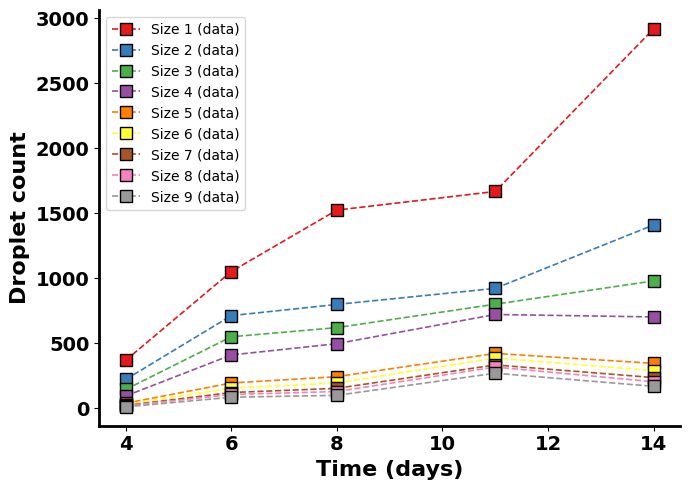

In [5]:
plotter = Plots(base_path='../')
max_size_class_shown = 9
plotter.plot_data_and_model_timecourse(
    model_sol=None, 
    data_array=timecourse_data, 
    max_size_class_shown=max_size_class_shown, 
    fig_size=(7,5))

---

## Section 2) Additive Normal noise model

For this section we assume additive normal noise, so

\begin{equation*}
    \phi_n^\text{data}(t_j) = \phi_n^\text{model}(t_j \, ; \, \bm{\theta}) + \varepsilon \quad ; \quad \varepsilon \sim \mathcal{N}(0, \sigma_n^2) \, .
\end{equation*}

### Section 2.1) Finding the MLEs

In order to get an initial guess for the parameters, we will try and find the MLEs, $\hat{\theta}$.

To do this, we will use an optimisation routine to find the combination of parameters that maximise the log-likelihood.



##### PINTS model

In [63]:
model = DropletModel(initial_conditions=initial_conditions)

problem = pints.MultiOutputProblem(model, data_times, timecourse_data)

param_mles = {}

##### Log-likelihood

In [64]:
log_likelihood = AdditiveNormalSigmaMLEIndicatorLogLikelihood(
    problem, 
    zero_tol=1
)

##### Optimisation

In [65]:
opt_lower_bounds = [0, 0, 0]
opt_upper_bounds = [1e4, 1e-3, 1e0]

opt_bounds = pints.RectangularBoundaries(opt_lower_bounds, opt_upper_bounds)
log_prior = pints.UniformLogPrior(opt_bounds)

opt_initial_position = log_prior.sample(1)

opt = pints.OptimisationController(
    log_likelihood, 
    opt_initial_position, 
    boundaries=opt_bounds, 
    method=pints.XNES
)

opt.set_log_to_screen(True)
opt_params, opt_max_likelihood = opt.run()

print('Estimated parameters:')
print(opt_params)

param_mles["b"] = opt_params[0]
param_mles["f"] = opt_params[1]
param_mles["g"] = opt_params[2]

Maximising LogPDF
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Current   Time m:s
0     7     -504.8911 -504.8911   0:00.0
1     11    -500.1335 -500.1335   0:00.1
2     16    -500.1335 -501.4453   0:00.1
3     22    -500.1335 -501.9008   0:00.1
20    138   -498.1041 -498.3095   0:00.3
40    278   -498.0651 -498.1029   0:00.6
60    418   -498.0129 -498.0133   0:01.0
80    558   -498.0127 -498.0131   0:01.3
100   698   -498.0126 -498.0126   0:01.6
120   838   -498.0126 -498.0126   0:02.0
140   978   -498.0126 -498.0126   0:02.3
160   1118  -498.0126 -498.0126   0:02.6
180   1258  -498.0126 -498.0126   0:02.9
200   1398  -498.0126 -498.0126   0:03.3
220   1538  -498.0126 -498.0126   0:03.6
240   1678  -498.0126 -498.0126   0:04.0
260   1818  -498.0126 -498.0126   0:04.3
280   1958  -498.0126 -498.0126   0:04.6
300   2098  -498.0126 -498.0126   0:05.0
320   2238  -498.0126 -498.0126   0:05.3
340   2378  -498.0126 

##### Get $\hat{\theta}$

In [66]:
print(opt_params)

[1.48152422e+03 1.52431824e-04 4.42657179e-01]


##### Calculate $\hat{\sigma}$

In [67]:
opt_sigma_mles = get_sigma_MLEs(
    model=model,
    data=timecourse_data,
    mle_params=opt_params,
    data_times=data_times,
    noise_model="additive normal"
)

print(f"{opt_sigma_mles}")

param_mles["sigma_mles"] = opt_sigma_mles

[704.59937579 320.99481546 305.5690377  281.88435021 106.76015379
 107.69735843  93.51835852  94.12985472  77.72753763  70.93172283
  14.66280361  60.14183813  54.63488814  13.30870863  46.12163723
  12.01766307  38.51395694  10.98667501  10.97488138  31.19435328
   9.96643254  25.84644789   8.80590002   8.56378798   8.20413941
  20.06157715   7.30312652   7.09733085   6.67866744  15.52105243
   5.76577426   5.61786796   5.31266386   5.17680284  11.65183311
   4.50863997   4.30664988   4.09680776   3.86581399   3.74831218
   3.59371936   3.45459571   3.32705846   3.19384898   3.10651345
   6.6485472    2.79214075   2.69246143   2.67485065   2.86216728
   7.71621055]


##### Plot the MLE solution

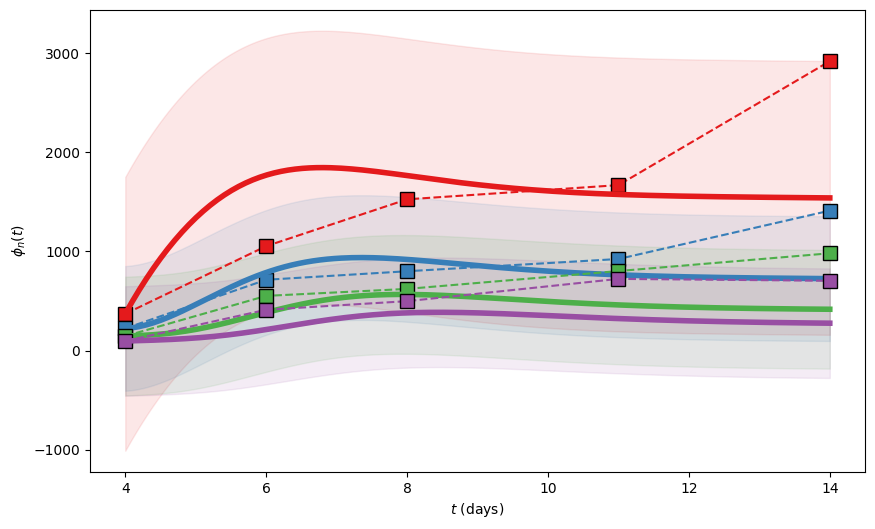

In [68]:
plot_mle_solution(model=model,
                  data=timecourse_data,
                  data_times=data_times,
                  param_mles=param_mles,
                  max_size_shown=4,
                  fig_size=(10,6))

---

### Section 2.2) - Using the MLEs to perform Bayesian inference

##### Get Bayesian chains

In [69]:
b_mle, f_mle, g_mle = param_mles["b"], param_mles["f"], param_mles["g"]
param_mles_model = [b_mle, f_mle, g_mle]

prior_factor = 4
prior_lower_bounds = np.asarray(param_mles_model) / prior_factor
prior_upper_bounds = np.asarray(param_mles_model) * prior_factor

bayesian_chains = get_mcmc_chains(
    log_likelihood=log_likelihood,
    apply_log_transform=True,
    mcmc_method=pints.HaarioBardenetACMC,
    max_mcmc_iterations=20000,
    num_chains=4,
    prior_lower_bounds=prior_lower_bounds,
    prior_upper_bounds=prior_upper_bounds,
    initial_mcmc_points=None,
    log_to_screen=True
)

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0         0         0.5       0          0:00.0
2     12     0.333     0         0.333     0.333      0:00.1
3     16     0.5       0         0.25      0.5        0:00.1
20    84     0.238     0.381     0.476     0.286      0:00.2
40    164    0.195122  0.39      0.39      0.268      0:00.4
60    244    0.262     0.361     0.377     0.23       0:00.6
80    324    0.222     0.432     0.37      0.272      0:00.7
100   404    0.267     0.406     0.406     0.277      0:00.9
120   484    0.273     0.413     0.43      0.248      0:01.0
140   564    0.284     0.433     0.411     0.241      0:01.2
160   644    0.298     0.422     0.429     0.261      0:01.4
180   724    0.304     0.436     0.42      0.287      0:01.5
Initial phase completed.
200   804    0.323     0.

##### Plot chains trace

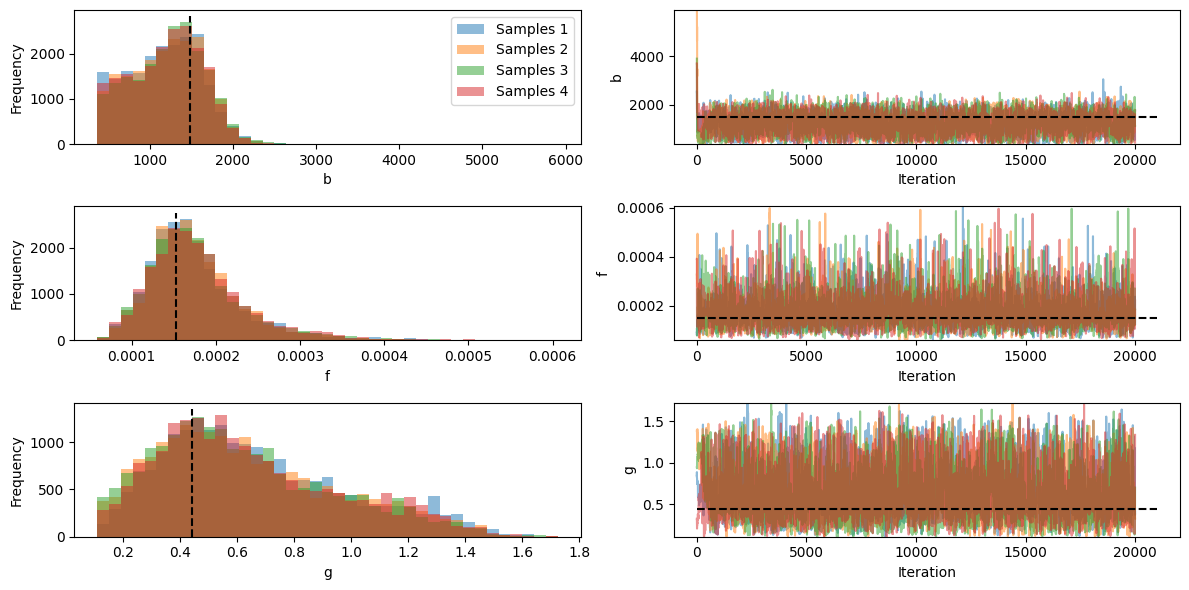

In [70]:
pints.plot.trace(
    bayesian_chains,
    parameter_names=model.param_names,
    ref_parameters=param_mles_model
)
plt.show()

##### Plot chains pairwise distributions

(<Figure size 900x900 with 9 Axes>,
 array([[<Axes: ylabel='Frequency'>, <Axes: >, <Axes: >],
        [<Axes: ylabel='f'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='b', ylabel='g'>, <Axes: xlabel='f'>,
         <Axes: xlabel='g'>]], dtype=object))

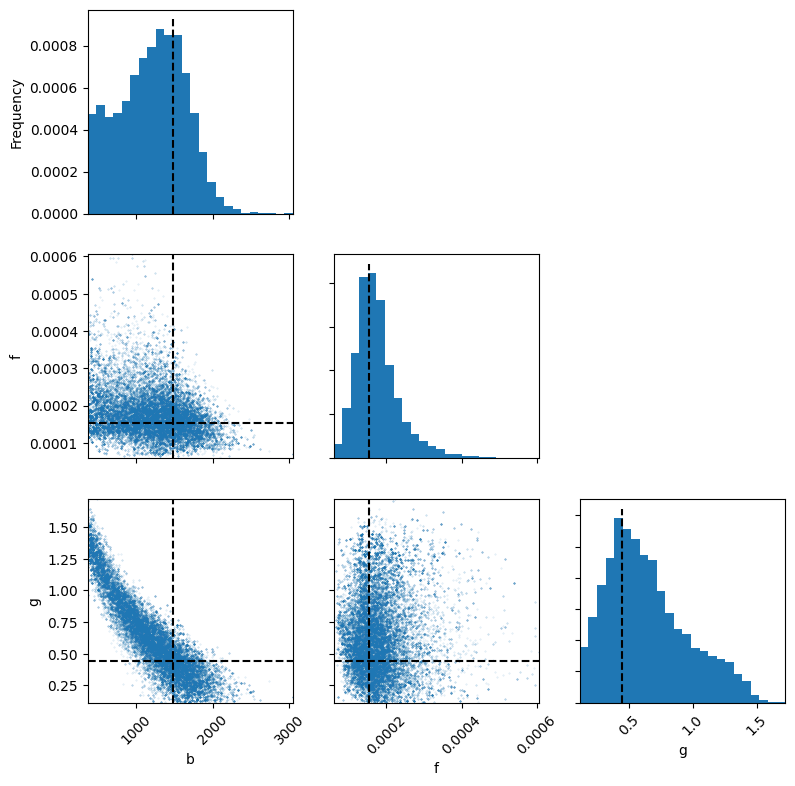

In [71]:
burnt_in_chains = bayesian_chains[:, int(bayesian_chains.shape[1]/2):, :]
stacked_chains = np.vstack(burnt_in_chains)

pints.plot.pairwise(
    stacked_chains, 
    parameter_names=model.param_names,
    ref_parameters=param_mles_model
)

We observe that $b$ and $g$ cannot not be individually identified from this data alone.

##### Posterior predictive check

MAPS: [1.20591543e+03 1.76678531e-04 6.43133877e-01]


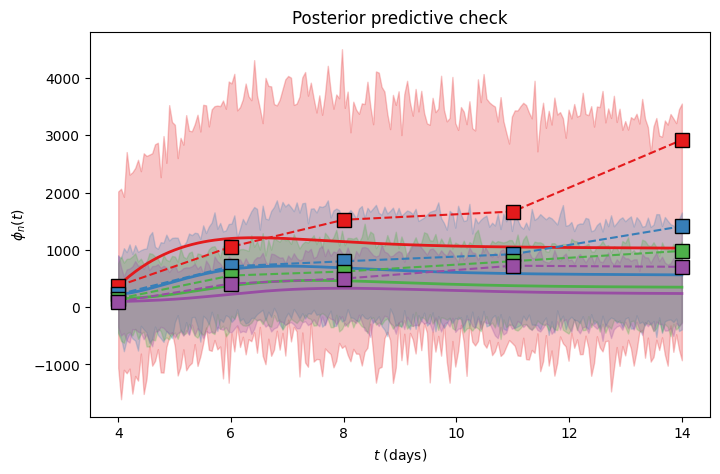

In [75]:
param_maps_model = np.mean(stacked_chains, axis=0)
sigma_maps = get_sigma_MLEs(
    model=model,
    data=timecourse_data,
    mle_params=param_maps_model,
    data_times=data_times
)

param_maps = {
    "b": param_maps_model[0],
    "f": param_maps_model[1],
    "g": param_maps_model[2],
    "sigma_mles": sigma_maps
}


additive_maps = np.mean(stacked_chains, axis=0)
print(f"MAPS: {additive_maps}")


additive_sigma_mles = get_sigma_MLEs(
    model=model,
    data=timecourse_data,
    mle_params=additive_maps,
    data_times=data_times,
    noise_model="additive normal"
)

posterior_predictive_plot(
    model=model,
    data=timecourse_data,
    model_param_chains=bayesian_chains,
    sigma_values=additive_sigma_mles
)

---

### Section 2.3) - MCMC with $b$ fixed

##### Run MCMC

In [17]:
b_fixed_value = 1.48152430e+03

b_fixed_model = DropletModel(
    model_type='fg', 
    initial_conditions=initial_conditions,
    fixed_param_value=b_fixed_value
)

b_fixed_problem = pints.MultiOutputProblem(b_fixed_model, data_times, timecourse_data)

b_fixed_log_likelihood = AdditiveNormalSigmaMLEIndicatorLogLikelihood(
    b_fixed_problem, 
    zero_tol=1
)

b_fixed_prior_lower_bounds = [1e-10, 1e-2]
b_fixed_prior_upper_bounds = [1e-3, 1e0]

b_fixed_chains = get_mcmc_chains(
    log_likelihood=b_fixed_log_likelihood,
    apply_log_transform=True,
    max_mcmc_iterations=20000,
    prior_lower_bounds=b_fixed_prior_lower_bounds,
    prior_upper_bounds=b_fixed_prior_upper_bounds
)

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0.5       0         0.5       0          0:00.0
2     12     0.667     0         0.667     0          0:00.1
3     16     0.5       0         0.75      0.25       0:00.1
20    84     0.571     0.524     0.619     0.619      0:00.2
40    164    0.537     0.512     0.634     0.61       0:00.4
60    244    0.525     0.508     0.508     0.557377   0:00.5
80    324    0.531     0.556     0.543     0.617284   0:00.7
100   404    0.554     0.535     0.545     0.634      0:00.9
120   484    0.595     0.529     0.529     0.653      0:01.1
140   564    0.574     0.532     0.553     0.624      0:01.2
160   644    0.571     0.559     0.528     0.615      0:01.4
180   724    0.569     0.564     0.536     0.619      0:01.6
Initial phase completed.
200   804    0.557     0.

##### Diagnostic plots

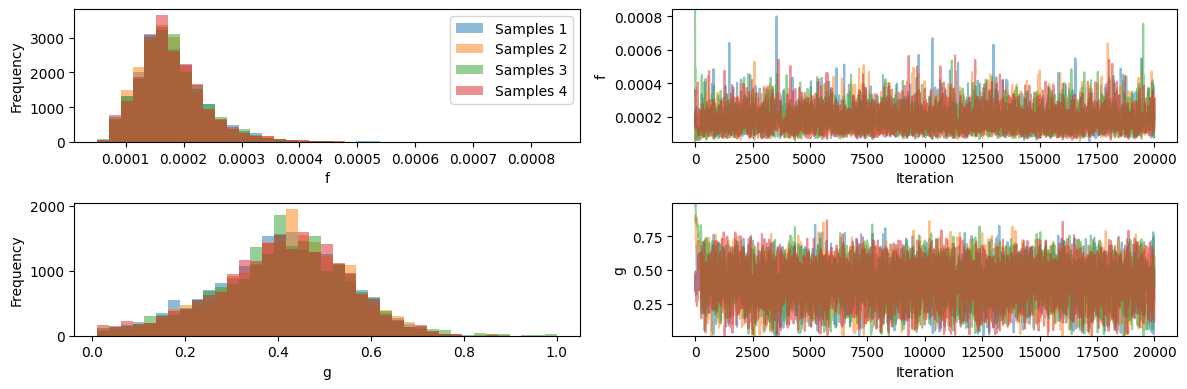

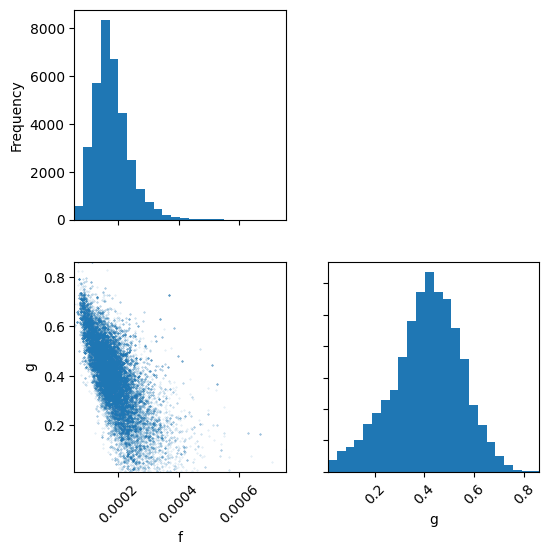

In [18]:
pints.plot.trace(b_fixed_chains, parameter_names=["f", "g"])
plt.show()

burnt_in_b_fixed_chains = b_fixed_chains[:, int(b_fixed_chains.shape[1]/2):, :]
stacked_b_fixed_chains = np.vstack(burnt_in_b_fixed_chains)

pints.plot.pairwise(
    stacked_b_fixed_chains, 
    parameter_names=["f", "g"]
)
plt.show()

##### Plot series using MAPS

MAPS: [1.48152430e+03 1.78500246e-04 4.08379133e-01]


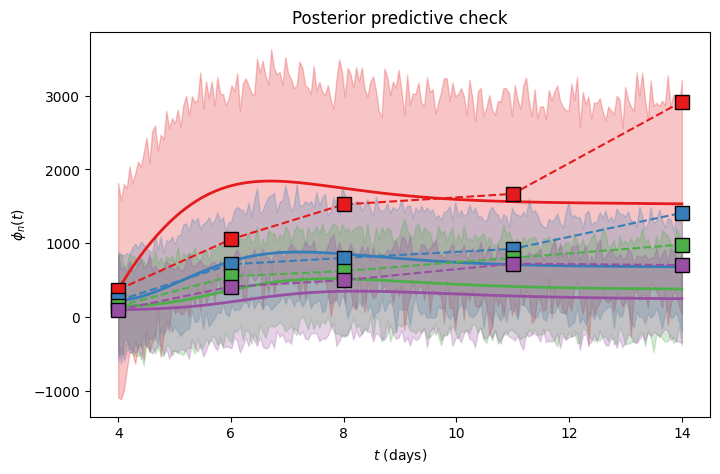

In [95]:
b_fixed_chains_means = np.mean(stacked_b_fixed_chains, axis=0)
b_fixed_maps = np.asarray([b_fixed_value] + list(b_fixed_chains_means))
print(f"MAPS: {b_fixed_maps}")


b_fixed_sigma_mles = get_sigma_MLEs(
    model=model,
    data=timecourse_data,
    mle_params=b_fixed_maps,
    data_times=data_times,
    noise_model="additive normal"
)

posterior_predictive_plot(
    model=model,
    data=timecourse_data,
    model_param_chains=b_fixed_chains,
    sigma_values=b_fixed_sigma_mles,
    fixed_parameter="b",
    fixed_parameter_value=b_fixed_maps[0]
)

---

### Section 2.4) - MCMC with $g$ fixed

##### Run MCMC

In [96]:
g_fixed_value = 4.42657138e-01

g_fixed_model = DropletModel(
    model_type='bf', 
    initial_conditions=initial_conditions,
    fixed_param_value=g_fixed_value
)

g_fixed_problem = pints.MultiOutputProblem(g_fixed_model, data_times, timecourse_data)

g_fixed_log_likelihood = AdditiveNormalSigmaMLEIndicatorLogLikelihood(
    g_fixed_problem, 
    zero_tol=1
)

g_fixed_prior_lower_bounds = [1e1, 1e-10]
g_fixed_prior_upper_bounds = [1e4, 1e-3]

g_fixed_chains = get_mcmc_chains(
    log_likelihood=g_fixed_log_likelihood,
    apply_log_transform=True,
    max_mcmc_iterations=20000,
    prior_lower_bounds=g_fixed_prior_lower_bounds,
    prior_upper_bounds=g_fixed_prior_upper_bounds
)

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0         0.5       0.5       0.5        0:00.0
2     12     0         0.667     0.333     0.333      0:00.0
3     16     0         0.75      0.5       0.5        0:00.1
20    84     0.238     0.286     0.429     0.524      0:00.2
40    164    0.244     0.244     0.415     0.488      0:00.4
60    244    0.295082  0.262     0.279     0.361      0:00.6
80    324    0.259     0.296     0.308642  0.333      0:00.7
100   404    0.248     0.287     0.317     0.277      0:00.9
120   484    0.256     0.298     0.306     0.281      0:01.1
140   564    0.255     0.277     0.305     0.291      0:01.3
160   644    0.248     0.298     0.298     0.317      0:01.4
180   724    0.26      0.320442  0.309     0.320442   0:01.6
Initial phase completed.
200   804    0.278607  0.

##### Diagnostic plots

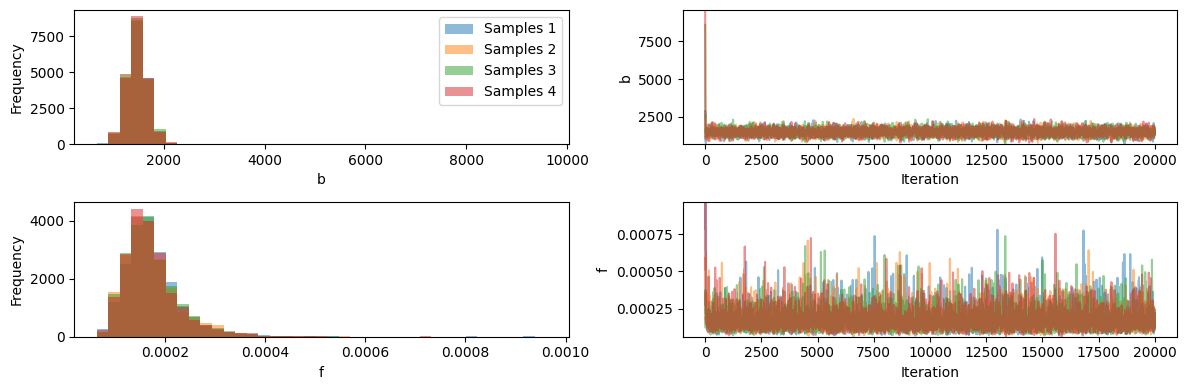

(<Figure size 600x600 with 4 Axes>,
 array([[<Axes: ylabel='Frequency'>, <Axes: >],
        [<Axes: xlabel='b', ylabel='f'>, <Axes: xlabel='f'>]], dtype=object))

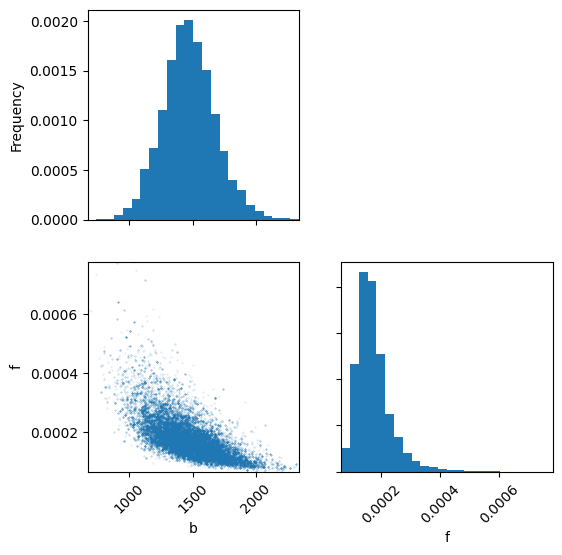

In [97]:
pints.plot.trace(g_fixed_chains, parameter_names=["b", "f"])
plt.show()

burnt_in_g_fixed_chains = g_fixed_chains[:, int(g_fixed_chains.shape[1]/2):, :]
stacked_g_fixed_chains = np.vstack(burnt_in_g_fixed_chains)

pints.plot.pairwise(
    stacked_g_fixed_chains, 
    parameter_names=["b", "f"]
)

##### Plot series using MAPS

MAPS: [1.47089814e+03 1.73720296e-04 4.42657138e-01]


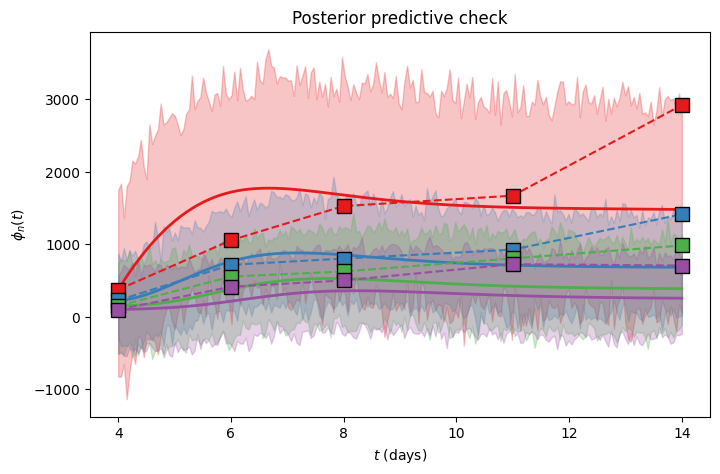

In [99]:
g_fixed_chains_means = np.mean(stacked_g_fixed_chains, axis=0)
g_fixed_maps = np.asarray(list(g_fixed_chains_means) + [g_fixed_value])
print(f"MAPS: {g_fixed_maps}")


g_fixed_sigma_mles = get_sigma_MLEs(
    model=model,
    data=timecourse_data,
    mle_params=g_fixed_maps,
    data_times=data_times,
    noise_model="additive normal"
)

posterior_predictive_plot(
    model=model,
    data=timecourse_data,
    model_param_chains=g_fixed_chains,
    sigma_values=g_fixed_sigma_mles,
    fixed_parameter="g",
    fixed_parameter_value=g_fixed_maps[2]
)

---

### Section 2.5) -  Re-parameterise, and infer $b = u + g \, v$

##### Re-parameterised model MCMC

In [100]:
reparameterised_model = ReparameterisedDropletModel(initial_conditions=initial_conditions)

reparameterised_problem = pints.MultiOutputProblem(reparameterised_model, data_times, timecourse_data)

reparameterised_log_likelihood = AdditiveNormalSigmaMLEIndicatorLogLikelihood(
    reparameterised_problem, 
    zero_tol=1
)
print(reparameterised_model.param_names)

print(reparameterised_log_likelihood.n_parameters())

reparameterised_prior_lower_bounds = [1e2, -5e3, 1e-10, 1e-2]
reparameterised_prior_upper_bounds = [1e4, -1e3, 1e-3, 1e0]

reparameterised_chains = get_mcmc_chains(
    log_likelihood=reparameterised_log_likelihood,
    apply_log_transform=False,
    max_mcmc_iterations=20000,
    prior_lower_bounds=reparameterised_prior_lower_bounds,
    prior_upper_bounds=reparameterised_prior_upper_bounds
)

['u', 'v', 'f', 'g']
4
Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0         0         0.5       0          0:00.0
2     12     0         0         0.333     0          0:00.0
3     16     0         0         0.25      0          0:00.0
20    84     0.143     0         0.0476    0.0476     0:00.0
40    164    0.0732    0.0244    0.0732    0.0488     0:00.1
60    244    0.0492    0.0492    0.0984    0.0492     0:00.1
80    324    0.0494    0.0741    0.0988    0.0494     0:00.2
100   404    0.0396    0.0693    0.0792    0.0396     0:00.2
120   484    0.0331    0.0579    0.0661    0.0413     0:00.2
140   564    0.0284    0.0496    0.0567    0.0426     0:00.2
160   644    0.0248    0.0497    0.0621    0.0435     0:00.3
180   724    0.0221    0.0442    0.0608    0.0442     0:00.3
Initial phase completed.
20

##### Diagnostic plots

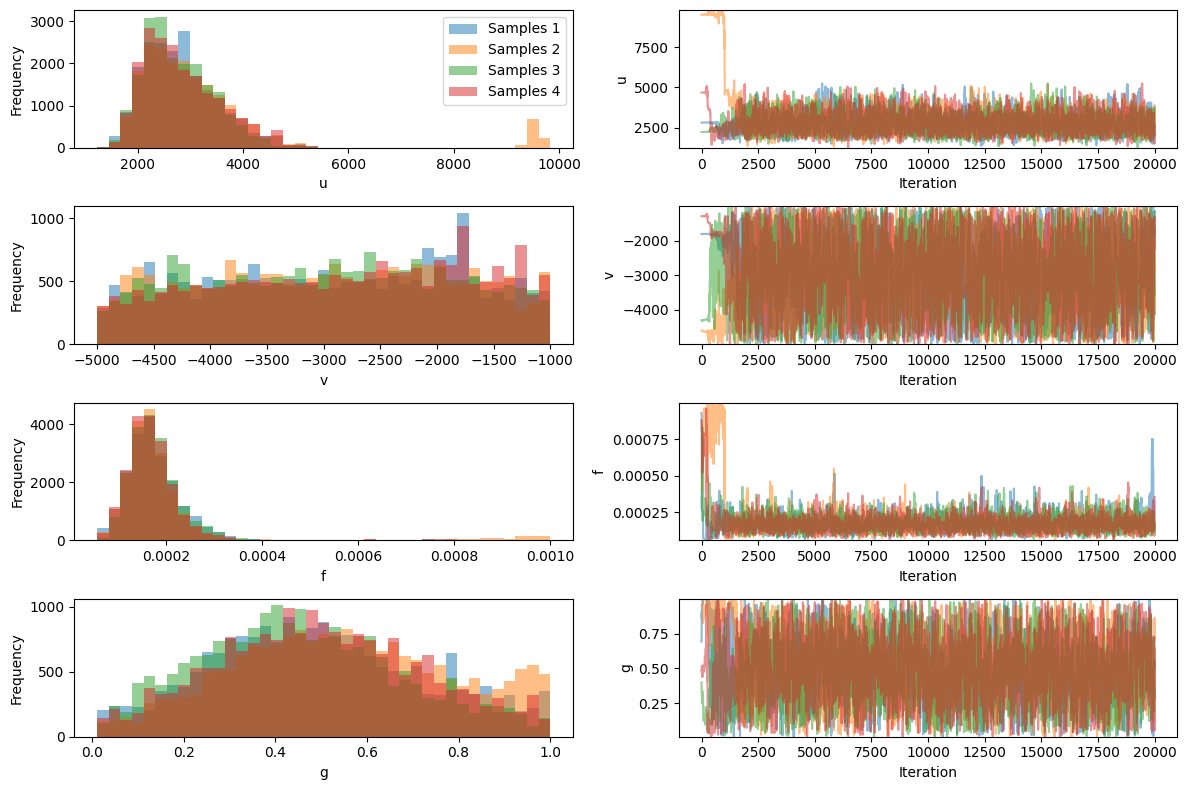

(<Figure size 1200x1200 with 16 Axes>,
 array([[<Axes: ylabel='Frequency'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='v'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='f'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: xlabel='u', ylabel='g'>, <Axes: xlabel='v'>,
         <Axes: xlabel='f'>, <Axes: xlabel='g'>]], dtype=object))

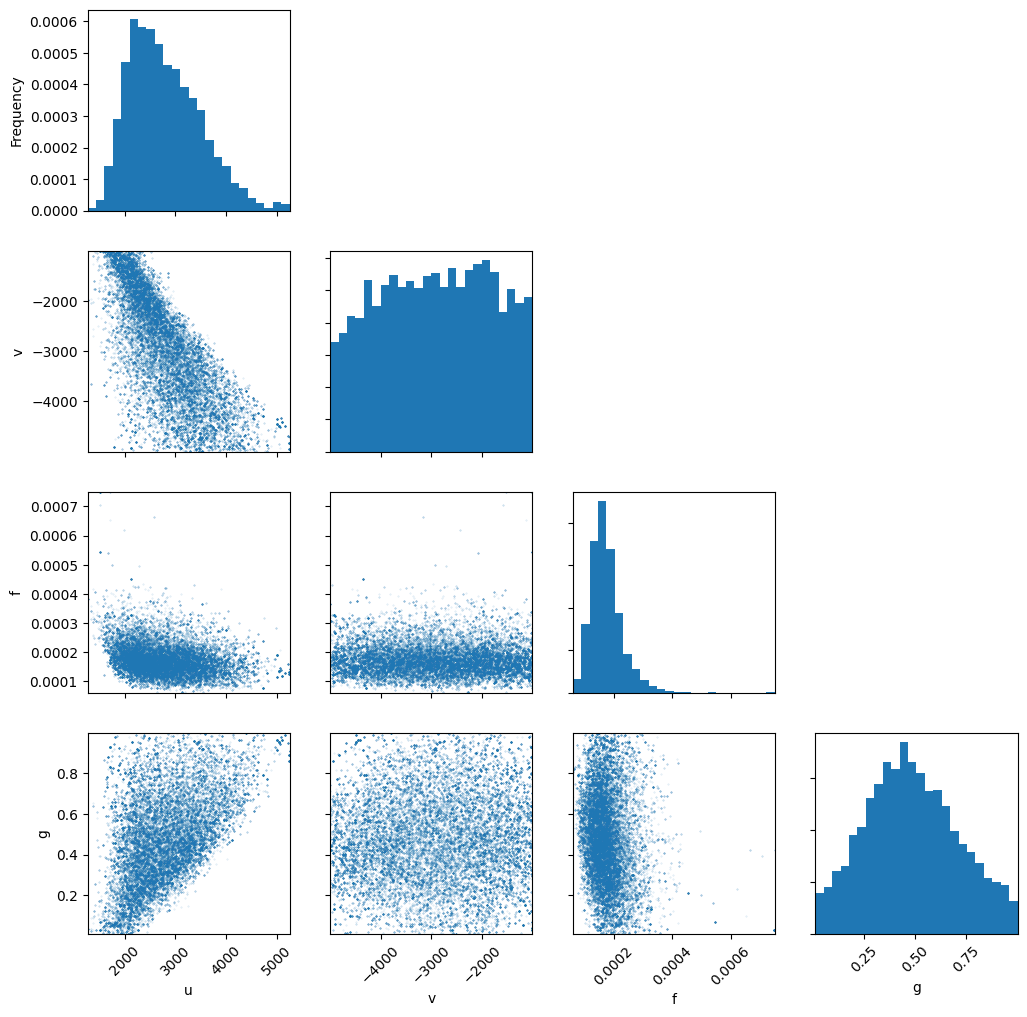

In [101]:
pints.plot.trace(reparameterised_chains, parameter_names=["u", "v", "f", "g"])
plt.show()

burnt_in_reparameterised_chains = reparameterised_chains[:, int(reparameterised_chains.shape[1]/2):, :]
stacked_reparameterised_chains = np.vstack(burnt_in_reparameterised_chains)

pints.plot.pairwise(
    stacked_reparameterised_chains, 
    parameter_names=["u", "v", "f", "g"]
)

##### Plot series using MAPS

MAPS: [1.42860880e+03 3.64845284e-04 5.58075485e-01]


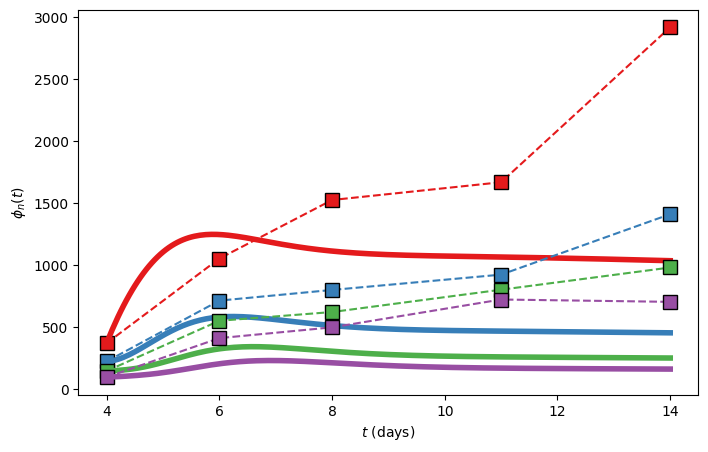

In [26]:
reparameterised_chains_means = np.mean(stacked_reparameterised_chains, axis=0)
u_mean = reparameterised_chains_means[0]
v_mean = reparameterised_chains_means[1]
f_mean = reparameterised_chains_means[2]
g_mean = reparameterised_chains_means[3]
b_mean = u_mean + v_mean * g_mean
reparameterised_maps = np.asarray([b_mean, f_mean, g_mean])
print(f"MAPS: {reparameterised_maps}")
plot_map_series(
    model=model,
    data=timecourse_data,
    data_times=data_times,
    param_maps=reparameterised_maps,
    max_size_shown=4
)

---

## Section 3) - Multiplicative normal noise

For this section we assume multiplicative normal noise, so

\begin{equation*}
    \phi_n^\text{data}(t_j) = \phi_n^\text{model}(t_j \, ; \, \bm{\theta}) (1 + \varepsilon) \quad ; \quad \varepsilon \sim \mathcal{N}(0, \sigma_n^2) \, .
\end{equation*}

##### Modules

In [ ]:
# import os
# os.chdir(os.path.dirname(os.getcwd()))

# import numpy as np
# from data_handler import DataHandler
# from droplet_model import DropletModel, ReparameterisedDropletModel
# from parameter_fitting import ParameterFitting
# from plots import Plots
# import matplotlib.pyplot as plt
# import pints
# import pints.plot
# from scipy.integrate import odeint
# from numba import njit
# import seaborn as sns
# from cycler import cycle

##### Log likelihood

In [27]:
import numpy as np
import pints

class MultiplicativeNormalSigmaMLEIndicatorLogLikelihood(pints.ProblemLogLikelihood):

    def __init__(self, problem, zero_tol=0.0):
        """
        Multiplicative noise log-likelihood with sigma profiled out by MLE.

        Parameters
        ----------
        problem : pints.Problem
            the PINTS problem that provides .n_outputs(), .n_times(), .evaluate(x) etc.
            It is assumed problem.evaluate(x) returns an array shaped (nt, no).
        zero_tol : float
            any per-output mean squared relative-error <= zero_tol is treated as
            "zero error" and that output is ignored.
        """
        super(MultiplicativeNormalSigmaMLEIndicatorLogLikelihood, self).__init__(problem)
        self._no = problem.n_outputs()
        self._np = problem.n_parameters()
        self._nt = problem.n_times()
        self._zero_tol = float(zero_tol)
        # store observed data values in same shape as problem.evaluate returns:
        # (nt, no). You used self._values in your additive class; keep same idea.
        # Ensure self._values is set before using the log-likelihood (as in your original code).
        # e.g. self._values = observed_data_array

    def __call__(self, x):
        # model prediction: shape (nt, no)
        model = self._problem.evaluate(x)

        # avoid shape mistakes
        if model.shape != self._values.shape:
            raise ValueError("Model and data shapes disagree: {} vs {}".format(model.shape, self._values.shape))

        # relative error (epsilon) per multiplicative model:
        # epsilon = (y_data / y_model) - 1  <=>  (y_data - y_model) / y_model
        # compute in a numerically stable way (but must divide by model)
        # if any model element is zero we'd get division by zero
        # we handle non-positive model entries below for included outputs.
        rel_error = (self._values - model) / model  # shape (nt, no)

        # per-output MLE of sigma^2: mean of squared relative errors
        sse = np.sum(rel_error**2, axis=0) / float(self._nt)  # length = no, this is sigma_hat_n^2

        # mask outputs that have non-zero SSE (use numeric tolerance)
        mask = sse > self._zero_tol
        k = int(np.count_nonzero(mask))  # number of included outputs

        # if nothing remains, return -inf (log-likelihood impossible under this param)
        if k == 0:
            return -np.inf

        # use only positive/valid SSEs
        sse_valid = sse[mask]  # length = k

        # Check model positivity for included outputs (multiplicative model requires positive model values)
        model_valid = model[:, mask]  # shape (nt, k)
        if np.any(model_valid <= 0.0):
            # could alternatively return a large negative value or apply different handling,
            # but returning -inf is consistent: parameter x makes model invalid for multiplicative noise.
            return -np.inf

        # ---- build profile log-likelihood ----
        # offset coming from substitution of sigma_hat (constant terms)
        offset = -0.5 * k * self._nt * (np.log(2.0 * np.pi) + 1.0)

        # term from the MLE-substituted variances:
        # profile term = -0.5 * T * sum_n log(sse_valid)
        log_term_sse = -0.5 * float(self._nt) * np.sum(np.log(sse_valid))

        # Jacobian term from change of variables (product of 1/y_model across included outputs and times):
        # = - sum_{n in included} sum_{j=1}^T log(y_model[j,n])
        jacobian_term = -np.sum(np.log(model_valid))

        # total profile log-likelihood
        return offset + log_term_sse + jacobian_term


##### Run MCMC

In [28]:
model = DropletModel(initial_conditions=initial_conditions)

problem = pints.MultiOutputProblem(model, data_times, timecourse_data)

multiplicative_log_likelihood = MultiplicativeNormalSigmaMLEIndicatorLogLikelihood(problem, zero_tol=1)

In [29]:

prior_lower_bounds = [1e2, 1e-6, 1e-2]
prior_upper_bounds = [5e4, 1e-3, 1e1]

xs = [[5e3, 2e-4, 1e0] for _ in range(4)]

multiplicative_bayesian_chains = get_mcmc_chains(
    log_likelihood=multiplicative_log_likelihood,
    apply_log_transform=True,
    mcmc_method=pints.HaarioBardenetACMC,
    max_mcmc_iterations=20000,
    num_chains=4,
    prior_lower_bounds=prior_lower_bounds,
    prior_upper_bounds=prior_upper_bounds,
    initial_mcmc_points=xs,
    log_to_screen=True
)

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0.5       0         0         0.5        0:00.0
2     12     0.333     0         0.333     0.333      0:00.0
3     16     0.25      0         0.25      0.25       0:00.0
20    84     0.19      0.0952    0.19      0.19       0:00.2
40    164    0.146     0.0732    0.146     0.0976     0:00.5
60    244    0.131     0.0492    0.0984    0.082      0:00.8
80    324    0.111     0.037     0.0741    0.0741     0:01.0
100   404    0.0891    0.0495    0.0594    0.0594     0:01.3
120   484    0.0826    0.0413    0.0744    0.0579     0:01.5
140   564    0.078     0.0355    0.0709    0.0567     0:01.7
160   644    0.0683    0.0373    0.0683    0.0559     0:02.0
180   724    0.0718    0.0442    0.0663    0.0552     0:02.2
Initial phase completed.
200   804    0.0746    0.

##### Diagnostic plots

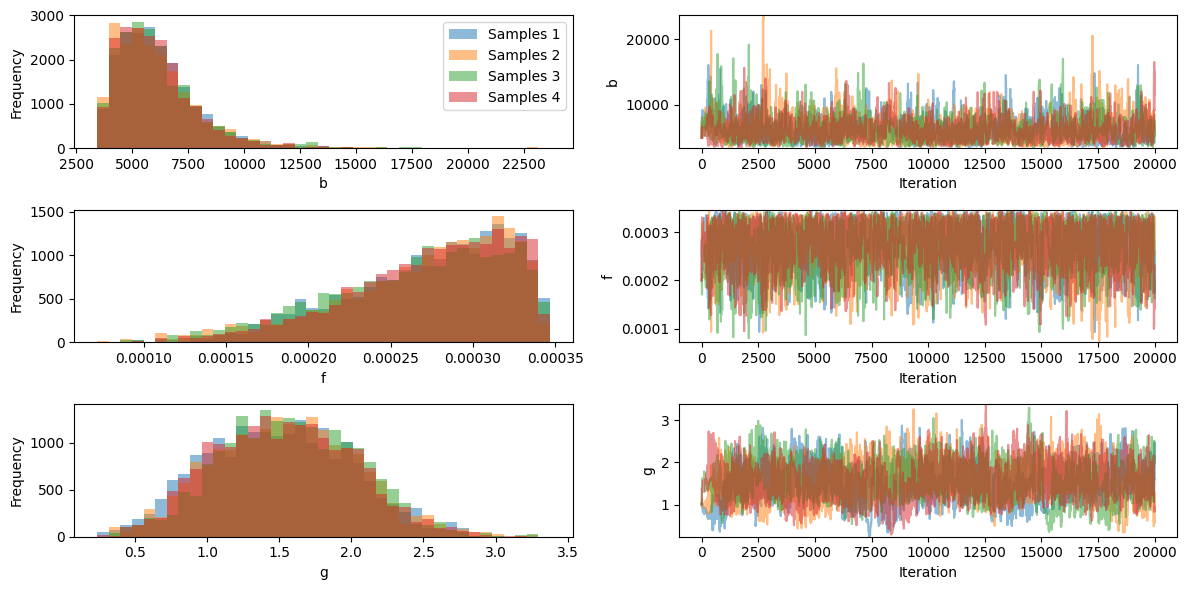

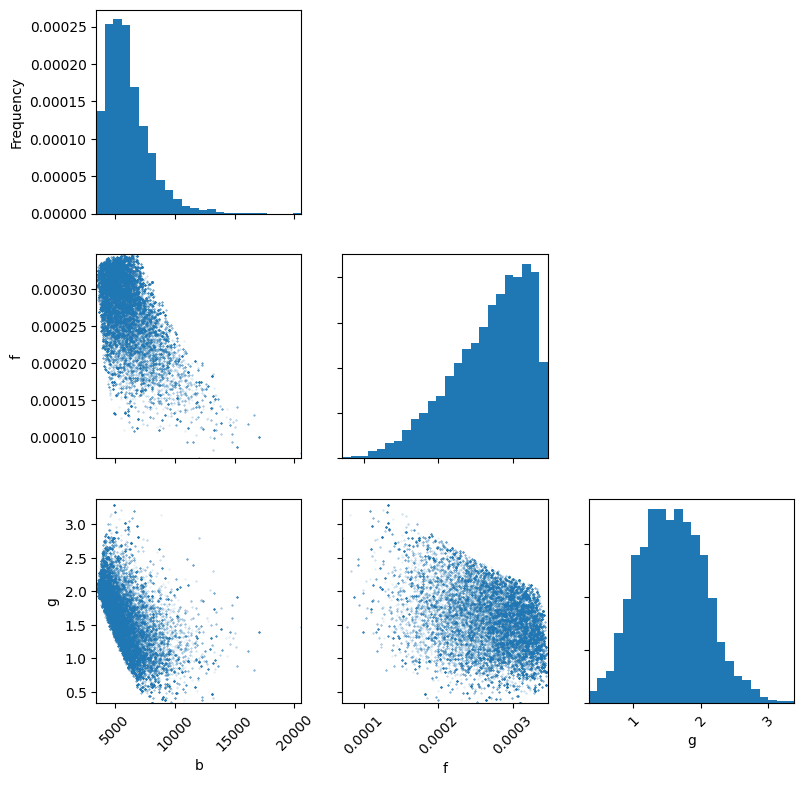

In [30]:
pints.plot.trace(multiplicative_bayesian_chains, parameter_names=["b", "f", "g"])
plt.show()

burnt_in_multiplicative_chains = multiplicative_bayesian_chains[:, int(multiplicative_bayesian_chains.shape[1]/2):, :]
stacked_multiplicative_chains = np.vstack(burnt_in_multiplicative_chains)

pints.plot.pairwise(
    stacked_multiplicative_chains, 
    parameter_names=["b", "f", "g"]
)
plt.show()

MAPS: [6.05311532e+03 2.69116554e-04 1.56448021e+00]


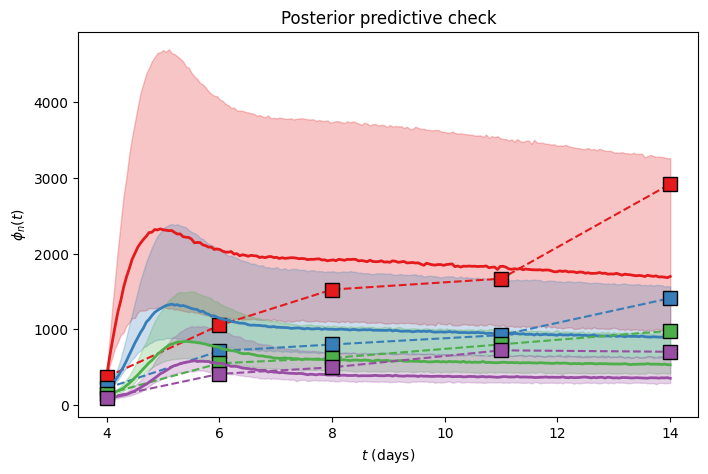

In [62]:
multiplicative_chains_means = np.mean(stacked_multiplicative_chains, axis=0)

multiplicative_maps = multiplicative_chains_means
print(f"MAPS: {multiplicative_maps}")


multiplicative_sigma_mles = get_sigma_MLEs(
    model=model,
    data=timecourse_data,
    mle_params=multiplicative_maps,
    data_times=data_times,
    noise_model="multiplicative normal"
)

posterior_predictive_plot(
    model=model,
    data=timecourse_data,
    model_param_chains=multiplicative_bayesian_chains,
    sigma_values=multiplicative_sigma_mles
)

---

## Section 4) - Lognormal noise model

For this section we assume log-normal noise, so

\begin{equation*}
    \phi_n^\text{data}(t_j) = \phi_n^\text{model}(t_j \, ; \, \bm{\theta}) \exp(\varepsilon) \quad ; \quad \varepsilon \sim \mathcal{N}(0, \sigma_n^2) \, .
\end{equation*}

##### Modules

In [ ]:
# import os
# os.chdir(os.path.dirname(os.getcwd()))

# import numpy as np
# from data_handler import DataHandler
# from droplet_model import DropletModel, ReparameterisedDropletModel
# from parameter_fitting import ParameterFitting
# from plots import Plots
# import matplotlib.pyplot as plt
# import pints
# import pints.plot
# from scipy.integrate import odeint
# from numba import njit
# import seaborn as sns
# from cycler import cycle

##### Log-likelihood

In [32]:
class LognormalSigmaMLEIndicatorLogLikelihood_Robust(pints.ProblemLogLikelihood):
    """
    Robust lognormal profile log-likelihood:
     - profiles sigma_n by MLE (mean squared log-residuals),
     - ignores outputs whose sigma_hat^2 <= zero_tol,
     - also ignores outputs that have any non-positive model or data values (instead of returning -inf).
    """
    def __init__(self, problem, zero_tol=0.0):
        super(LognormalSigmaMLEIndicatorLogLikelihood_Robust, self).__init__(problem)
        self._no = problem.n_outputs()
        self._np = problem.n_parameters()
        self._nt = problem.n_times()
        self._zero_tol = float(zero_tol)
        # set self._values externally to observed data shape (nt, no)

    def __call__(self, x):
        model = self._problem.evaluate(x)        # (nt, no)
        if model.shape != self._values.shape:
            raise ValueError("Model and data shapes disagree: {} vs {}".format(model.shape, self._values.shape))

        # compute log values but allow NaNs, we'll handle them via mask
        with np.errstate(divide='ignore', invalid='ignore'):
            log_values = np.log(self._values)
            log_model  = np.log(model)
            log_resid  = log_values - log_model   # may contain NaN/inf where <=0

        # per-output sum-of-squared log-residuals (NaNs propagate)
        sse_raw = np.nansum(log_resid**2, axis=0)  # treat NaNs as missing in sum
        # count number of finite entries per output (so we can divide by actual T_finite)
        finite_counts = np.sum(np.isfinite(log_resid), axis=0).astype(float)

        # For an output with no finite log-residuals, mark its sse as Inf so it gets excluded
        bad_mask_anyno = finite_counts == 0.0
        sse_raw[bad_mask_anyno] = np.inf
        finite_counts[bad_mask_anyno] = 1.0  # avoid divide by zero; sse_raw set to inf anyway

        # compute per-output mean squared log-resid using available finite entries
        sse = sse_raw / finite_counts   # length = no

        # Now mask outputs to include:
        # - must have sse > zero_tol
        # - must have all finite log-residuals (or at least one finite), already handled
        mask = (sse > self._zero_tol) & np.isfinite(sse)

        # Also require that BOTH data and model are strictly positive for the included outputs:
        # If any timepoint in that output has nonpositive model or data, exclude that output.
        pos_mask = np.all(self._values > 0.0, axis=0) & np.all(model > 0.0, axis=0)
        mask = mask & pos_mask

        k = int(np.count_nonzero(mask))
        if k == 0:
            return -np.inf

        sse_valid = sse[mask]                        # length k
        model_valid = model[:, mask]                 # (nt, k)
        values_valid = self._values[:, mask]         # (nt, k)

        # offset from profiling sigma
        offset = -0.5 * k * self._nt * (np.log(2.0 * np.pi) + 1.0)

        # -0.5 * T * sum_n log(sse_valid)
        # Note: use the actual finite_counts per included output to be consistent.
        finite_counts_valid = finite_counts[mask]
        # If T differs per-output, use the per-output count
        log_term_sse = -0.5 * np.sum(finite_counts_valid * np.log(sse_valid))

        # Jacobian term (lognormal): - sum_{n in included} sum_j log(y_data_{j,n})
        jacobian_term = -np.sum(np.log(values_valid))

        return offset + log_term_sse + jacobian_term


##### Run MCMC

In [33]:
model = DropletModel(initial_conditions=initial_conditions)

problem = pints.MultiOutputProblem(model, data_times, timecourse_data)

lognormal_log_likelihood = LognormalSigmaMLEIndicatorLogLikelihood_Robust(problem, zero_tol=1)

In [34]:
prior_lower_bounds = [1e2, 1e-6, 1e-2]
prior_upper_bounds = [5e4, 1e-3, 1e1]

xs = [[1e3, 2e-5, 1e-1] for _ in range(4)]

lognormal_bayesian_chains = get_mcmc_chains(
    log_likelihood=lognormal_log_likelihood,
    apply_log_transform=True,
    mcmc_method=pints.HaarioBardenetACMC,
    max_mcmc_iterations=20000,
    num_chains=4,
    prior_lower_bounds=prior_lower_bounds,
    prior_upper_bounds=prior_upper_bounds,
    initial_mcmc_points=xs,
    log_to_screen=True
)

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0.5       0         0.5       0.5        0:00.0
2     12     0.667     0         0.667     0.667      0:00.0
3     16     0.5       0.25      0.5       0.5        0:00.1
20    84     0.429     0.381     0.619     0.619      0:00.2
40    164    0.415     0.293     0.366     0.439      0:00.4
60    244    0.295082  0.23      0.262     0.311      0:00.7
80    324    0.259     0.185     0.21      0.235      0:00.9
100   404    0.208     0.168     0.168     0.218      0:01.2
120   484    0.182     0.157     0.149     0.182      0:01.4
140   564    0.17      0.141844  0.135     0.156      0:01.7
160   644    0.155     0.124     0.124     0.143      0:02.0
180   724    0.149     0.121547  0.116     0.133      0:02.2
Initial phase completed.
200   804    0.139     0.

##### Diagnostic plots

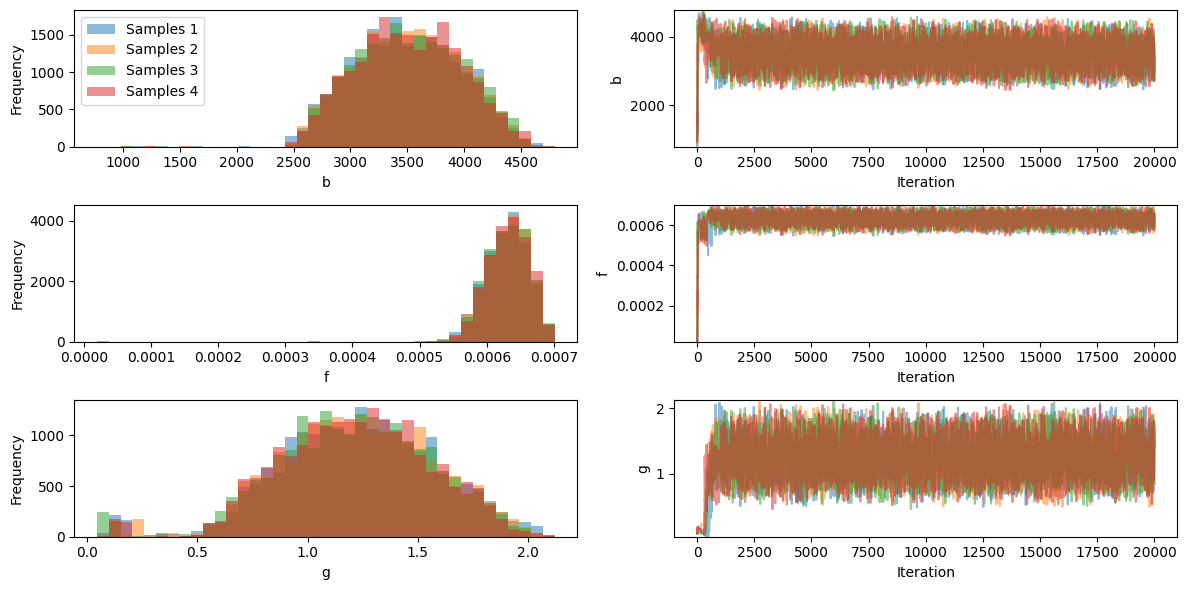

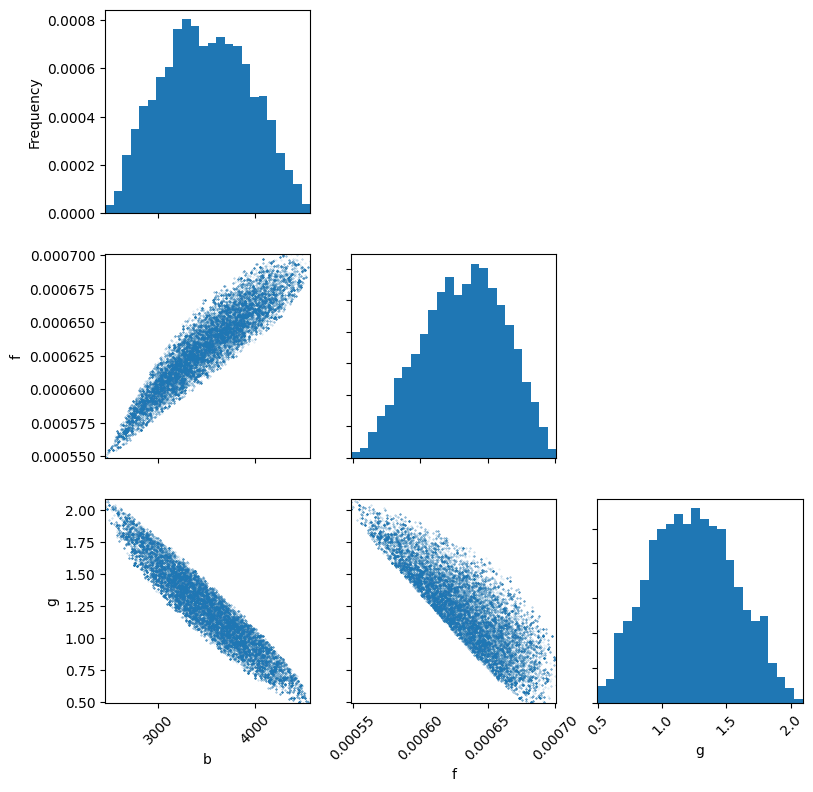

In [35]:
pints.plot.trace(lognormal_bayesian_chains, parameter_names=["b", "f", "g"])
plt.show()

burnt_in_lognormal_chains = lognormal_bayesian_chains[:, int(lognormal_bayesian_chains.shape[1]/2):, :]
stacked_lognormal_chains = np.vstack(burnt_in_lognormal_chains)

pints.plot.pairwise(
    stacked_lognormal_chains, 
    parameter_names=["b", "f", "g"]
)
plt.show()

MAPS: [3.49215355e+03 6.31540727e-04 1.24056412e+00]


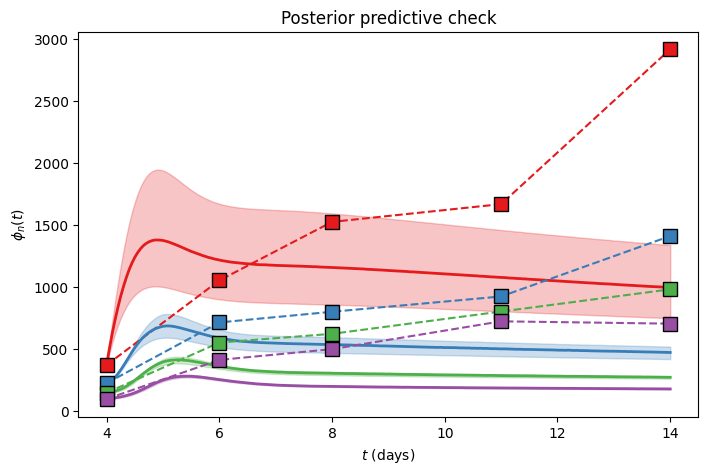

In [61]:
lognormal_chains_means = np.mean(stacked_lognormal_chains, axis=0)
lognormal_maps = lognormal_chains_means
print(f"MAPS: {lognormal_maps}")

lognormal_sigma_mles = get_sigma_MLEs(
    model=model,
    data=timecourse_data,
    mle_params=lognormal_maps,
    data_times=data_times,
    noise_model="lognormal"
)

posterior_predictive_plot(
    model=model,
    data=timecourse_data,
    model_param_chains=lognormal_bayesian_chains,
    sigma_values=lognormal_sigma_mles
)

---

## Section 5) - Autoregression noise

##### Log-likelihood

In [37]:
class LognormalAR1SigmaMLEIndicatorLogLikelihood_Robust(pints.ProblemLogLikelihood):
    """
    Robust lognormal AR(1) profile log-likelihood.

    Model on log-scale:
        log(y_data) = log(y_model(theta)) + e_t,
        e_t = phi * e_{t-1} + eta_t,  eta_t ~ N(0, sigma^2)

    For each output n we:
      - compute log-residuals r_{t,n} = log(y_data) - log(y_model)
      - estimate phi_hat_n by conditional least squares: A/B (safe for B == 0)
      - compute S_n = (1-phi^2)*r1^2 + sum_{t=2} (r_t - phi r_{t-1})^2
      - sigma2_hat_n = S_n / T_n (T_n = number of finite log-residuals for that output)
      - mask outputs with sigma2_hat_n <= zero_tol, or invalid phi (|phi| >= 1), or nonpositive data/model
    The returned value is the profile log-likelihood with sigma profiled out.
    """
    def __init__(self, problem, zero_tol=0.0):
        super(LognormalAR1SigmaMLEIndicatorLogLikelihood_Robust, self).__init__(problem)
        self._no = problem.n_outputs()
        self._np = problem.n_parameters()
        self._nt = problem.n_times()
        self._zero_tol = float(zero_tol)
        # observed data must be set to self._values (shape (nt, no)) externally

    def __call__(self, x):
        model = self._problem.evaluate(x)        # (nt, no)
        if model.shape != self._values.shape:
            raise ValueError("Model and data shapes disagree: {} vs {}".format(model.shape, self._values.shape))

        # Compute logs allowing NaNs where values <= 0 (we'll mask later)
        with np.errstate(divide='ignore', invalid='ignore'):
            log_values = np.log(self._values)    # (nt, no)
            log_model  = np.log(model)           # (nt, no)
            log_resid  = log_values - log_model  # (nt, no), may contain NaN/inf

        # Count finite entries per output and sum-of-squared residuals (treat NaNs as missing)
        finite_mask = np.isfinite(log_resid)                 # (nt, no)
        finite_counts = np.sum(finite_mask, axis=0).astype(float)  # length = no

        # For outputs with no finite entries, force them to be excluded
        no_data_mask = finite_counts == 0.0
        if np.any(no_data_mask):
            # ensure we don't divide by zero later
            finite_counts[no_data_mask] = 1.0

        # Prepare arrays for phi_hat, S (numerators/denominators)
        # We compute sums only over indices where both r_t and r_{t-1} are finite.
        # Build shifted versions with masking
        r = log_resid  # (T, N)
        r_t = r[1: , :]      # shape (T-1, N)  (r_2 ... r_T)
        r_t_1 = r[:-1, :]    # shape (T-1, N)  (r_1 ... r_{T-1})
        valid_pair = np.isfinite(r_t) & np.isfinite(r_t_1)  # (T-1, N)

        # A = sum r_t * r_{t-1} over valid pairs
        A = np.nansum(np.where(valid_pair, r_t * r_t_1, 0.0), axis=0)
        # B = sum r_{t-1}^2 over valid pairs
        B = np.nansum(np.where(valid_pair, r_t_1**2, 0.0), axis=0)

        # Estimate phi_hat safely: if B == 0 set phi_hat = 0 (i.e., no lag information)
        phi_hat = np.zeros(self._no, dtype=float)
        nonzero_B = B != 0.0
        phi_hat[nonzero_B] = A[nonzero_B] / B[nonzero_B]

        # If phi_hat is NaN/inf for any reason, mark those as invalid (will be excluded)
        invalid_phi = ~np.isfinite(phi_hat)

        # Now compute S_n using available finite entries:
        # S = (1-phi^2) * r1^2 + sum_{t=2} (r_t - phi r_{t-1})^2  (sum only over finite pairs)
        # For the first term r1 must be finite
        r1 = r[0, :]  # (N,) may be NaN for some outputs
        r1_finite = np.isfinite(r1)

        # compute residual difference (t >= 2) but only where pair is finite
        diff = np.where(valid_pair, (r_t - (phi_hat[np.newaxis, :] * r_t_1)), 0.0)  # (T-1, N)
        sum_sq_diff = np.sum(diff**2, axis=0)  # (N,) sums only over valid pairs since others were zeroed

        # For S we need (1-phi^2)*r1^2 only when r1 finite, else treat r1^2 as 0 and reduce effective count
        r1_sq = np.where(r1_finite, r1**2, 0.0)

        S_raw = (1.0 - phi_hat**2) * r1_sq + sum_sq_diff  # (N,)

        # Effective counts T_n: number of finite residuals for that output.
        T_effective = finite_counts.copy()  # float

        # If an output has finite pairs fewer than 1 etc, T_effective may be < 1 — keep it as is.
        # For outputs with no finite entries we previously set finite_counts to 1 and S_raw will be 0 -> sigma2=0 -> excluded.

        # Compute sigma^2 hat per output:
        sigma2_hat = S_raw / T_effective  # (N,)  (may be zero/inf/NaN)

        # Now decide which outputs to include:
        # - must have sigma2_hat > zero_tol
        # - must have all included data/model strictly positive (we require all timepoints positive here)
        pos_mask = np.all(self._values > 0.0, axis=0) & np.all(model > 0.0, axis=0)

        # - phi must be finite and within (-1,1) for stationarity and for log(1-phi^2) to be finite
        phi_valid_mask = np.isfinite(phi_hat) & (np.abs(phi_hat) < 1.0)

        # combine masks
        mask = (sigma2_hat > self._zero_tol) & pos_mask & phi_valid_mask & (~no_data_mask)

        # Count included outputs
        k = int(np.count_nonzero(mask))
        if k == 0:
            return -np.inf

        # Grab valid arrays
        sigma2_valid = sigma2_hat[mask]
        phi_valid = phi_hat[mask]
        T_valid = T_effective[mask].astype(float)

        # Rebuild values_valid for jacobian term (only included outputs)
        values_valid = self._values[:, mask]  # (nt, k)

        # offset from profiling sigma (constant term from substituting sigma_hat)
        offset = -0.5 * k * np.mean(T_valid) * (np.log(2.0 * np.pi) + 1.0)
        # Note: previous implementations used T (constant across outputs). Here we use mean(T_valid) only for that constant;
        # the main T-dependent terms below use the correct per-output T_valid.

        # log-term from sigma substitution: -0.5 * sum_n [ T_n * log(sigma2_n) ]
        log_term_sse = -0.5 * np.sum(T_valid * np.log(sigma2_valid))

        # phi / stationarity term: + 0.5 * sum_n log(1 - phi_n^2)
        phi_term = 0.5 * np.sum(np.log(1.0 - phi_valid**2))

        # Jacobian term for lognormal (data-only): - sum_{n in included} sum_j log(y_data_{j,n})
        jacobian_term = -np.sum(np.log(values_valid))

        # Total profile log-likelihood
        return offset + phi_term + log_term_sse + jacobian_term

##### Run MCMC

In [38]:
model = DropletModel(initial_conditions=initial_conditions)

problem = pints.MultiOutputProblem(model, data_times, timecourse_data)

autoregressive_log_likelihood = LognormalAR1SigmaMLEIndicatorLogLikelihood_Robust(problem, zero_tol=1)

In [42]:
prior_lower_bounds = [1e1, 1e-8, 1e-3]
prior_upper_bounds = [5e3, 1e-4, 1e0]

xs = [[1e3, 2e-5, 1e-1] for _ in range(4)]

autoregressive_bayesian_chains = get_mcmc_chains(
    log_likelihood=autoregressive_log_likelihood,
    apply_log_transform=True,
    mcmc_method=pints.HaarioBardenetACMC,
    max_mcmc_iterations=20000,
    num_chains=4,
    prior_lower_bounds=prior_lower_bounds,
    prior_upper_bounds=prior_upper_bounds,
    initial_mcmc_points=xs,
    log_to_screen=True
)

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0.5       0         0.5       0          0:00.0
2     12     0.333     0.333     0.333     0.333      0:00.0
3     16     0.25      0.5       0.25      0.25       0:00.0
20    84     0.667     0.238     0.429     0.143      0:00.1
40    164    0.585     0.171     0.488     0.293      0:00.2
60    244    0.525     0.18      0.475     0.279      0:00.3
80    324    0.506     0.235     0.494     0.284      0:00.4
100   404    0.505     0.238     0.446     0.297      0:00.4
120   484    0.463     0.256     0.413     0.289      0:00.5
140   564    0.44      0.27      0.404     0.27       0:00.6
160   644    0.429     0.298     0.378882  0.261      0:00.6
180   724    0.414     0.287     0.365     0.249      0:00.7
Initial phase completed.
200   804    0.403     0.

##### Diagnostic plots

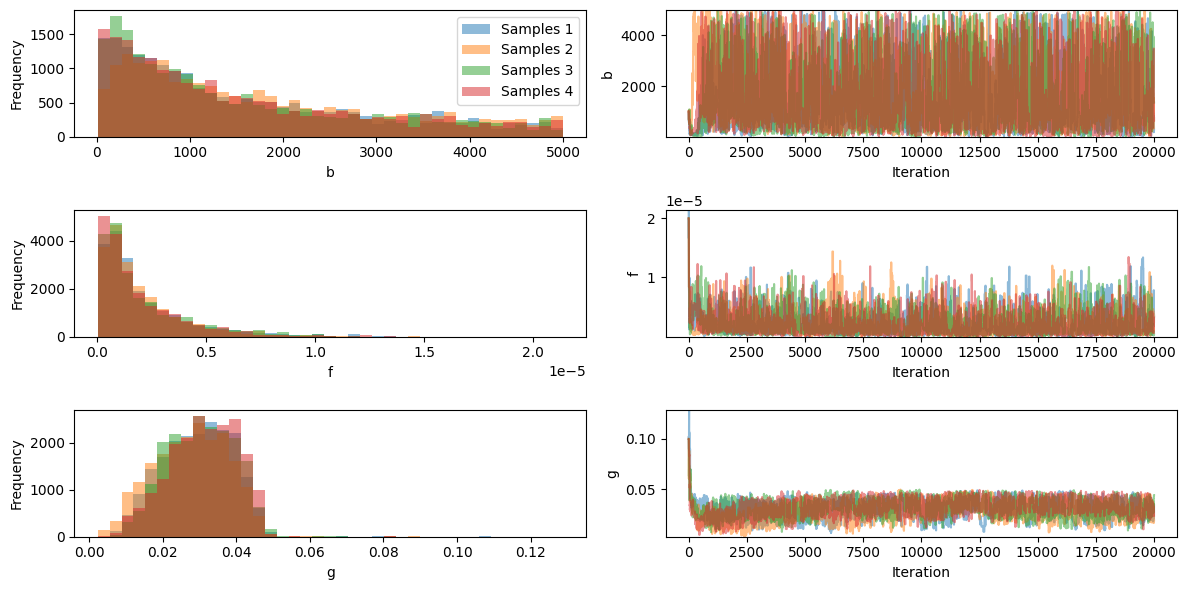

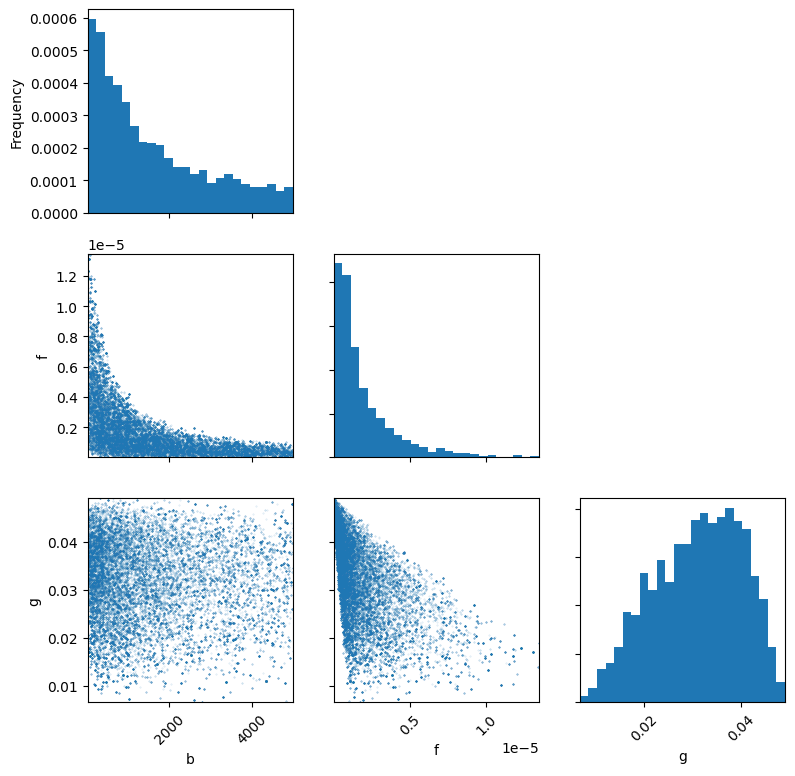

In [43]:
pints.plot.trace(autoregressive_bayesian_chains, parameter_names=["b", "f", "g"])
plt.show()

burnt_in_autoregressive_chains = autoregressive_bayesian_chains[:, int(autoregressive_bayesian_chains.shape[1]/2):, :]
stacked_autoregressive_chains = np.vstack(burnt_in_autoregressive_chains)

pints.plot.pairwise(
    stacked_autoregressive_chains, 
    parameter_names=["b", "f", "g"]
)
plt.show()